# 5. 서포트 벡터 머신

**기본설정**

파이썬 3.7 이상을 요구한다.

In [1]:
import sys

assert sys.version_info >= (3, 7)

사이킷런 1.0.1 이상을 요구한다.

In [2]:
import sklearn

assert sklearn.__version__ >= "1.0.1"

다음은 이미지에 포함된 폰트 크기를 설정한다.

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 5.1 선형 SVM 분류

붓꽃 데이터에서 세토사(setosa) 품종과 버시컬러(versicolor) 품종만을 대상으로 선형 SVM 분류기(하드 마진 분류)를 학습시킨다.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values # 특성 2개 (꽃잎 길이와 너비)
y = iris.target                                                 # 타깃 (품종)

setosa_or_versicolor = (y == 0) | (y == 1)                      # 세토사와 버시컬러만 대상으로.
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=float("inf"))                  # C=무한대. 즉, 하드 마진 분류기임.
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

아래 함수는 SVM 분류 모델로 학습된 내용을 그래프로 보여준다.
3개의 인자가 요구된다.

* `svm_clf`: 학습된 SVM 모델
* `xmin`, `xmax`: 그래프의 x축 좌표 구간

In [5]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정경계에서 w0*x0 + w1*x1 + b = 0. 따라서 x1 = -w0/w1 * x0 - b/w1.
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1] # 결정경계

    # 마진과 도로 경계
    margin = 1/w[1]                                  # 마진(도로 폭)
    gutter_up = decision_boundary + margin           # 도로 경계(윗쪽)
    gutter_down = decision_boundary - margin         # 도로 경계(아랫쪽)
    
    # 서포트 벡터 그리기
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
                zorder=-1)

    # 결정 경게와 결정 경계 도로 그리기
    plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
    plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)


- 왼편 그림: 일반적인 선형 분류의 단점을 보여주기 위해 일부러 선분을 극단적으로 그림.
- 오른편 그림: SVM (하드 마진) 분류의 장점을 잘 보여줌.

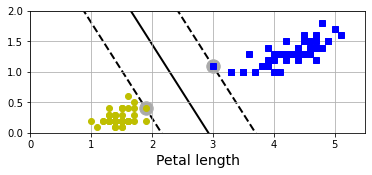

In [6]:
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.axis([0, 5.5, 0, 2])
plt.gca().set_aspect("equal")
plt.grid()

plt.show()

### 5.1.1. 하드 마진 분류

아래 코드는 붓꽃 데이터에 이상치 두 개를 추가할 때 SVM을 이용한 하드 마진 분류의 문제를 보여준다.

* 왼편 그림에 사용된 이상치의 꽃잎 길이/너비 특성: `[3.4, 1.3]`
* 오른편 그림에 사용된 이상치의 꽃잎 길이/너비 특성: `[3.2, 0.8]`

In [7]:
# 이상치 두 개
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])

# 왼편 그림 훈련 세트: 첫째 이상치 추가
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)

# 오른편 그림 훈련 세트: 둘째 이상치 추가
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

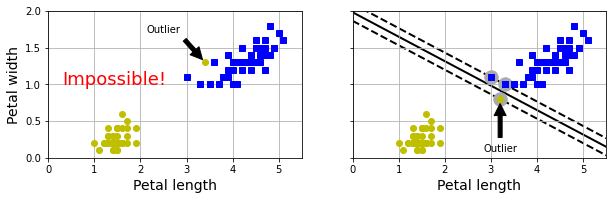

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

# 왼편 그림: 하드 마진 분류 불가능
plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", color="red", fontsize=18)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.annotate(
    "Outlier",
    xy=(X_outliers[0][0], X_outliers[0][1]),
    xytext=(2.5, 1.7),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

# 오른편 그림: 좋지 않은 하드 마진 분류. SVC와 linear 커널 사용.
svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length")
plt.annotate(
    "Outlier",
    xy=(X_outliers[1][0], X_outliers[1][1]),
    xytext=(3.2, 0.08),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
)
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

### 5.1.2. 소프트 마진 분류

아래 코드는 마진 오류를 허용하는, 즉 __소프트 마진 분류__를 지원하는 선형 SVM 학습법을 보여준다. 

* `LinearSVC`: 선형 SVM 이진 분류 모델. 
* 훈련 세트: 붓꽃 데이터 전체
* 타깃: 버지니카 품종 여부 (음성 0, 양성 1)
* 표준화 축척 조정 전처리 사용

__주의사항:__ `LinearSVC` 모델의 `C`에 의한 규제에 편향(절편)도 포함된다.
따라서 평균을 빼서 0으로 편향을 없애는 것이 중요하다. 
하지만 표준화 축척 조정을 하면 자연스럽게 해결된다.

In [9]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values  #특성: 꽃잎 길이, 꽃잎 너비
y = (iris.target == 2)                                           # 타깃: 버지니카(Iris-Verginica) 품종 여부

svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

`[5.5, 1.7]` 특성을 갖는 붓꽃에 대한 예측은 양성, 즉 버지니카 품종이이며,
`[5.0, 1.5]` 특성을 갖는 붓꽃에 대한 예측은 음성, 즉 버지니카 품종이 아니다.

In [10]:
X_new = [[5.5, 1.7], [5.0, 1.5]]
svm_clf.predict(X_new)

array([ True, False])

결정 함숫값이 각각 양수와 음수로 계산된다.

In [11]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

아래 코드는 소프트 마진 분류에 사용되는 규제(`C`)의 역할을 보여주는 그림을 그린다. 
규제 `C`에 선형적으로 반비례하여 규제 강도가 정해진다. 
`C=float("inf")`, 즉 무한대이면 마진을 전혀 허용하지 않는 하드 마진 분류 모델이 된다.

- `svm_clf1`: `C=1`, 즉 다소 많은 마진 오류 허용. 도로폭 큼. 규제는 강함.
- `svm_clf2`: `C=100`, 보다 적은 마진 오류 허용. 도로폭 보다 좁아짐. 규제는 보다 약함.

In [12]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, max_iter=10_000, random_state=42)
svm_clf2 = LinearSVC(C=100, max_iter=10_000, random_state=42)

scaled_svm_clf1 = make_pipeline(scaler, svm_clf1)
scaled_svm_clf2 = make_pipeline(scaler, svm_clf2)

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=100, max_iter=10000, random_state=42))])

&#x270b; __참고: 원시 데이터(raw data)의 결정경계__

훈련을 통해 학습된 결정경계의 파라미터는 모두 표준화된 값들을 대상으로 하였기 때문에
원시 데이터에 대한 결정경계 도로와 서포트 벡터를 그림으로 표시하려면 표준화 과정을 되돌리는 값을
사용해야 한다.

$\mathbf{x}$를 원시 데이터(raw data) 벡터라고 하고 $\mathbf{z}$를 표준화된 벡터이라 할 때 다음 관계가 성립한다. 

$$
\mathbf{z} = \frac{\mathbf{x}-\mu}{\sigma} \tag{*}
$$

* $\mu$: 평균값(mean)
* $\sigma$: 표준편차(standard deviation)

훈련된 `LinearSVC` 모델의 결정경계 함수(decision function)는 아래 선형함수이다.

$$
h(\mathbf{z}) = \theta_0 + \theta_1 z_1 + \cdots + \theta_n z_n
$$

원시 데이터 $\mathbf{x}$에 대한 결정경계 또한 위 결정경계 함수에 의존하도록 해야 한다. 
$\mathbf{x}$와 결정경계 함수와의 관계를 확인하기 위해 위 식에 $(*)$ 를 대입하여
$x_i$와 결정경계 함수 사이의 관계를 확인한다.

$$
\begin{align*}
\theta_0 + \theta_1 z_1 + \cdots + \theta_n z_n &= \theta_0 + \theta_1 \frac{x_1-\mu}{\sigma} + \cdots + \theta_n \frac{x_n-\mu}{\sigma} \\
&= \left [\, \theta_1 (-\mu/\sigma) + \cdots + \theta_n (-\mu/\sigma) + \theta_0\, \right] + (\theta_1/\sigma) x_1 + \cdots + (\theta_n/\sigma) x_n \\
&= h(-\mu / \sigma) + (\theta_1/\sigma) x_1 + \cdots + (\theta_n/\sigma) x_n
\end{align*}
$$

결론적으로, 원시 데이터의 각 특성 $x_i$에 대한 파라미터 $\theta'_i$와 편항 $\theta'_0$은 아래와 같다.

$$
\begin{align*}
\theta'_i & = \theta_i/\sigma \\[1ex]
\theta'_0 & = h (-\mu / \sigma)
\end{align*}
$$

참고: https://github.com/ageron/handson-ml/issues/250

아래 코드는 위 설명을 반영하여 원시 데이터에 대한 결정경계 함수의 파라미터와 편향을 계산한다. 
코드에 사용된 객체의 속성은 다음과 같다.

* 'LinearSVC.coef_[0]' 속성: 학습된 파라미터 벡터 $\mathbf{w}$ 저장
* 'LinearSVC.decision_function()' 메서드: 결정 함수 
* 'StandardScaler.mean_' 속성: 원시 데이터의 평균값 저장
* 'StandardScaler.scale_' 속성: 원시 데이터의 표준편차 저장

In [13]:
# 축척이 조정되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_]) # 절편
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_]) # 절편
w1 = svm_clf1.coef_[0] / scaler.scale_                           # 기울기 파라미터
w2 = svm_clf2.coef_[0] / scaler.scale_                           # 기울기 파라미터

# 새로운 파라미터와 편향 지정
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기: libsvm과 달리 liblinear 라이브러리에서 제공되지 않기에 직접 넣어줌.
# 부울 인덱싱을 이용하여 결정경계 도로 안에 위치한 값들을 서포트 벡터로 지정함.
t = y * 2 - 1                                                   # +1, -1 값
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()       # 결정경계 +- 1 안에 있는 데이터
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()       # 결정경계 +- 1 안에 있는 데이터
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

`plot_svc_decision_boundary()` 함수를 이용하여 `C` 값의 영향력을 보여주는 그림을 그린다.

* 왼편 그림: `C=1` 일 때.
* 오른편 그림: `C=100` 일 때.

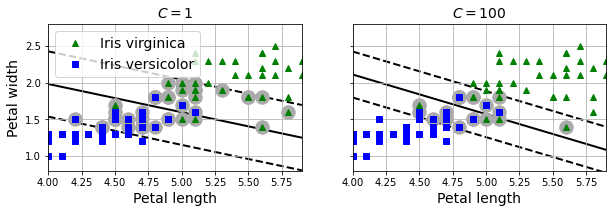

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 2.7), sharey=True)

# 왼편 그림: svm_clf1 모델
plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.title(f"$C = {svm_clf1.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

# 오른편 그림: svm_clf2 모델
plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length")
plt.title(f"$C = {svm_clf2.C}$")
plt.axis([4, 5.9, 0.8, 2.8])
plt.grid()

plt.show()

## 5.2.  비선형 SVM 분류

비선형 분류를 지원하는 SVM 모델은 사이킷런의 `SVC` 클래스이며, `LinearSVC` 클래스는 선형 분류만 지원한다. 

**다항 특성 추가 + 선형 SVM**

아래 코드는 moons 데이터셋을 불러온다. 
moons 데이터셋은 지정된 수의 데이터가 선형 분류가 불가능한 두 개의 반달 모양으로 구분되어 있다.

- 표준 정규분포를 따르도록 데이터셋이 생성됨.

In [15]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

# 100개의 샘플로 구성된 moons 데이터셋 준비
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

`X`는 x, y 좌표로 구성된 100개의 데이터를 담는다.

In [16]:
X.shape

(100, 2)

`y`는 100개 샘플의 레이블을 담고 있다.

In [17]:
y.shape

(100,)

아래 함수는 moons 데이터셋을 색깔과 모양으로 구분한 산점도를 그린다.

In [18]:
# 산점도 그리기 함수
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")   # 파랑 네모: 음성 데이터
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")   # 초록 세모: 양성 데이터
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

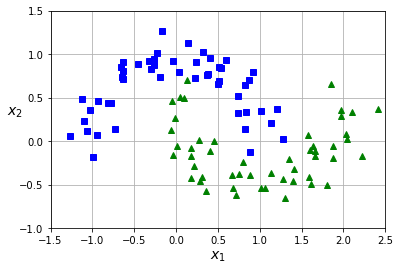

In [19]:
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

아래 코드는 3차 다항 특성을 추가할 경우 moons 데이터셋을 선형 분류로 해결할 수 있음을 보여주는
그림을 그린다.

- `PolynomialFeatures(degree=3)`: 3차 다항 특성까지 추가
- `StandardScaler()`: 이미 표준 정규분포를 따르기에 굳이 필요 없음 

In [20]:
polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
#     StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, random_state=42)
)
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

아래 함수는 훈련된 SVM 모델의 결정경계를 그려준다.

In [21]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

3차 다항 특성을 추가하여 훈련된 SVM 분류기의 성능을 아래 그림이 확인시켜 준다.

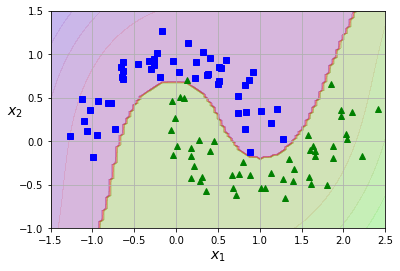

In [22]:
plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

### 5.2.1. 다항 커널

다항 특성 추가 기법은 모든 선형 회귀/분류 모델과 함께 사용할 수 있다.
하지만 다항 특성을 추가해서 훈련하는 비용이 경우에 따라 매우 비쌀 수 있다.

그런데 SVM의 경우 __커널 트릭__(kernel trick)을 사용하면 실제로는 특성을 추가하지 않지만
특성을 추가한 효과를 얻을 수 있다. 
`SVC` 모델의 경우 `poly` 커널과 적절한 다항 차수(degree)를 지정하면 
해당 차수만큼의 다항 특성을 추가한 효과를 낸다.

예를 들어 아래 코드는 3차와 10차 다항 특성을 추가한 효과를 이용하여 moons 데이터셋을 분류한 
결과를 그림으로 보여준다.

* 표준화 축척 조정 적용
* `kernel=poly`: 다항 커널 선택
* 다항 특성
    - 왼편: `degree=3` 
    - 오른편: `degree=10` 
* `coef0`: 식 5-10(p.  225)의 $r$에 해당하는 값이며, 값에 비례하여 추가되는 고차항의 영향력이 세짐. 기본값은 0.
    - 왼편: `coef0=1`
    - 오른편: `coef0=100`
* `C=5`: 마진 허용 정도

In [23]:
from sklearn.svm import SVC

# 3차 다항 커널 활용
poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

# 10차 다항 커널 활용
poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

`plot_predictions()` 함수를 활용하여 두 개의 그래프를 그린다.

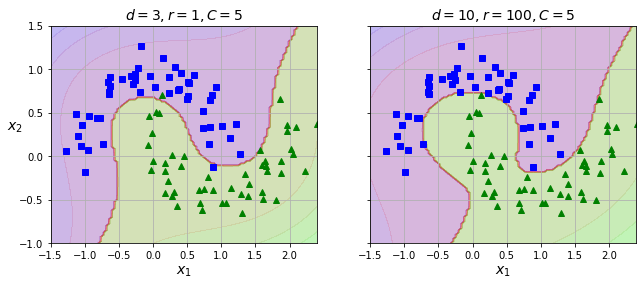

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

# 왼편 그림
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$")

# 왼편 그림
plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$")
plt.ylabel("")

plt.show()

### 5.2.2. 유사도 특성

가우시안 RBF 함수를 정의한다.

In [25]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

### 5.2.3. 가우시안 RBF 커널

RBF 커널을 이용하면 다항 커널의 경우처럼 유사도 특성을 실제로는 추가하지 않지만
추가한 효과를 내게 할 수 있다. 
사용법은 `kernel="rbf"`와 적절한 `gamma` 하이퍼파라미터 값을 지정하면 된다.

In [26]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

아래 코드는 `gamma`와 `C`의 조합 네 경우를 그림으로 보여준다. 

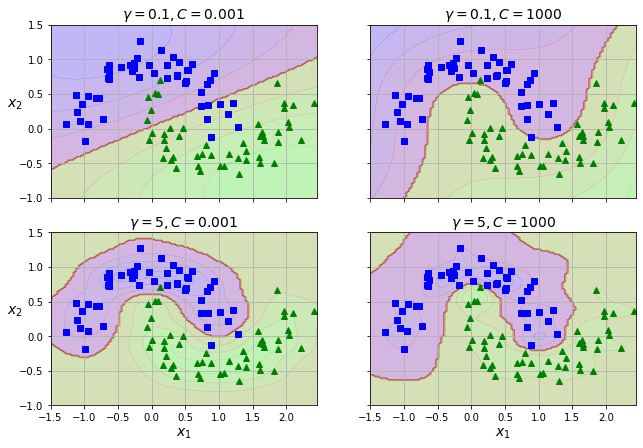

In [27]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

# RBF 커널 사용 SVC 모델 4 개 리스트
svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

# 그림 그리기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(fr"$\gamma = {gamma}, C = {C}$")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

## 5.3. SVM 회귀

아래 코드는 선형 SVM 회귀를 설명하기 위해 선형 회귀 학습이 가능한 50개의 샘플을 잡음을 섞어 생성한다.

In [28]:
from sklearn.svm import LinearSVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

두 개의 `LinearSVR` 모델을 훈련시킨다.

* `epsilon=0.5`/`epsilon=1.2`: 결정 도로의 폭 지정. 기본값은 0.
* `C=1`: 마진 오류 허용 정도. 기본값은 1이며 규제 세기는 `C` 크기에 반 비례.

In [29]:
svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, random_state=42))
svm_reg.fit(X, y)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, random_state=42))
svm_reg2.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=1.2, random_state=42))])

`find_support_vectors()` 함수는 마진 오류 샘플들의 인덱스를 찾는다.

In [30]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

In [31]:
# 두 `LinearSVR` 회귀 모델의 마진 오류
svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

# 경계도로 폭(epsilon)을 보여주기 위한 좌표 지정
eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

`plot_svm_regression()` 함수는 SVM 회귀 결과를 결정경계와 함께 그림으로 그려준다. 
사용된 인자는 다음과 같다.

* `svm_reg`: 훈련된 `LinearSVR` 모델
* `X`, `y`: 데이터셋(특성과 타깃)
* `axes`: x/y 축 구간 지정

In [32]:
def plot_svm_regression(svm_reg, X, y, axes):
    # 결정경계 선과 도로 경계 그리기
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2) # 결정경계 선 (검은 실선)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)                       # 위쪽 도로 경계 (검은 파선)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)                       # 아랫쪽 도로 경계 (검은 파선)
    
    # X 데이터셋의 샘플 중에서 마진 오류 샘플 표시하기 (분홍 원)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)

    # X, y 데이터셋 표기 (파랑 점)
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

아래 코드는 `epsilon`을 달리하는 두 `LinearSVR` 모델의 훈련 결과를 보여준다.

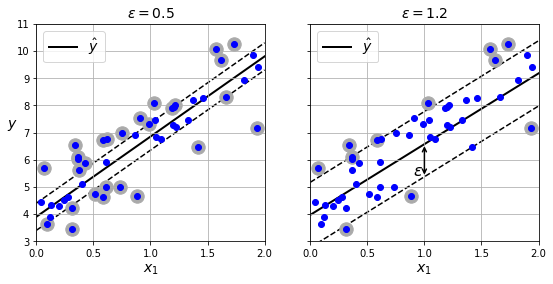

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

# 왼편 그림
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(fr"$\epsilon = {svm_reg[-1].epsilon}$")
plt.ylabel(r"$y$", rotation=0)
plt.grid()

# 오른편 그림
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(fr"$\epsilon = {svm_reg2[-1].epsilon}$")

# x1=1을 이용하여 결정경계 도로 폭(epsilon) 위아래 화살표로 표시하기
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)

plt.grid()
plt.show()

아래 코드는 다중 커널을 이용하는 비선형 SVM 회귀를 설명하기 위해 
50개의 샘플을 2차 다항식과 잡음을 이용하여 생성한다.

In [34]:
from sklearn.svm import SVR

np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

**참고:** 사이킷런 최신 버전에서 `gamma="scale"`이 기본값이다. 
그러면 `gamma`가 아래 값으로 자동 지정된다.

$$
\frac{1}{\text{특성 수} \cdot \text{특성의 분산}}
$$

2차 다항 커널을 사용하는 두 개의 `SVR` 모델을 훈련시킨다. `C` 규제를 달리한다.

* `kernel=poly`: 다항 커널
* `degree=2`: 2차 다항식 추가(효과)
* `epsilon=0.1`: 결정 도로. 조금 작게.
* `C=100`/`C=0.01`: 마진 오류 허용 정도가 다름.

In [35]:
svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, degree=2, kernel='poly'))])

아래 코드는 마진 오류 허용 정도 `C`를 달리하며 2차 다항 커널을 사용하는 두 `SVR` 모델의 훈련 결과를 보여준다.

| 왼편 그래프(C=100)    | 오른편 그래프(C=0.01)    |
| -------------: | -------------: |
| 규제 보다 약함 | 규제 보다 강함 |
| 샘플에 더 민감 | 샘플에 덜 민감 |
| 마진 오류 보다 적게 | 마진 오류 보다 많이  |

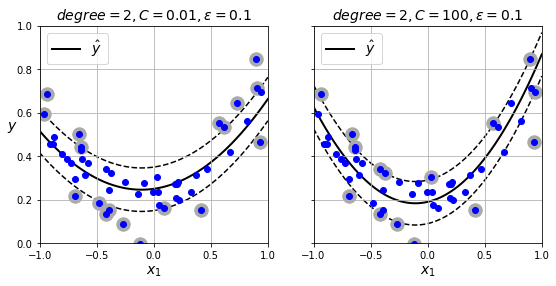

In [36]:
svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

# 왼편 그림: C=0.01
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"$degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          fr"\epsilon={svm_poly_reg[-1].epsilon}$")
plt.ylabel(r"$y$", rotation=0)
plt.grid()

# 오른편 그림: C=100
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"$degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          fr"\epsilon={svm_poly_reg2[-1].epsilon}$")
plt.grid()
plt.show()

## 부록: 배치 경사 하강법을 이용한 선형 SVM 구현

훈련셋은 붓꽃 꽃잎의 길이와 너비만을 사용하며, 타깃은 버지니카 품종 여부이다.

In [37]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

`MyLinearSVC` 클래스를 선언한다.
비용(손실) 함수는 다음과 같다.

$$
\begin{align*}
J(\mathbf{w}, b) & = \dfrac{1}{2} \mathbf{w}^T \mathbf{w} \,+\, C {\displaystyle \sum_{i=1}^{m}\max\left(0, 1 - t^{(i)} (\mathbf{w}^T \mathbf{x}^{(i)} + b) \right)} \\[.5ex]
\mathbf{w}^T \mathbf{w} & = w_1^2 + \cdots + w_n^2 \\[.5ex]
\mathbf{w}^T \mathbf{x}^{(i)} & = w_1 x_1^{(i)} + \cdots + w_n x_n^{(i)}
\end{align*}
$$

**주의사항:** SVM 이론을 설명할 때 편의상 
파라미터를 $\theta_0, \dots, \theta_n$ 대신에 절편과 특성 파라미터 벡터를
아래처럼 분리해서 사용한다.

$$
\begin{align*}
b &= \theta_0 \\
w_i &= \theta_i \quad (i = 1, \dots, n)
\end{align*}
$$

In [38]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000,
                 random_state=None):
        self.C = C
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
        self.random_state = random_state

    # 학습 스케줄
    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # 편향과 가중치 초기화
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1)  # 특성 가중치
        b = 0                               # 편향

        # t = -1(음성) 또는 1(양성). 
        m = len(X)
        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t                         # 비용함수 계산용
        
        # 에포크별 비용(손실) 저장
        self.Js=[]

        # 훈련: 경사하강법
        for epoch in range(self.n_epochs):
            # 서포트 벡터(마진 오류)
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel() # 서포트 벡터 위치 확인 부울 마스크
            X_t_sv = X_t[support_vectors_idx]                      # 서포트 벡터(부울 인덱싱 활용)
            t_sv = t[support_vectors_idx]                          # 서포트 벡터의 양성/음성 여부

            # 비용(손실) 계산: 서포트 벡터만 계산. 정상 분류된 샘플은 어차피 0이 더해짐.
            J = 1/2 * (w * w).sum() + self.C * ((1 - X_t_sv.dot(w)).sum() - b * t_sv.sum())
            self.Js.append(J)

            # 그레이디언트 계산: 특성 가중치와 편향 따로따로 계산
            w_gradient_vector = w - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -self.C * t_sv.sum()
                
            # 특성 가중치와 편향 업데이트
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            
        # 훈련 후: 편향, 특성 가중치, 서포트 벡터(마진 오류) 저장
        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()    # 서포트 벡터 위치 확인 부울 마스크
        self.support_vectors_ = X[support_vectors_idx]            # 서포트 벡터(부울 인덱싱 활용)
        return self

    # 결정 함수
    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]
    
    # 예측 함수
    def predict(self, X):
        return self.decision_function(X) >= 0

`MyLinearSVC` 모델을 훈련시킨다. (사이킷런의 SVC 모델 보다 좀 많이 느리다.)

In [39]:
C = 2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000,
                      random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[ True],
       [False]])

훈련 과정 중에 비용함숫값의 변화는 다음과 같다.

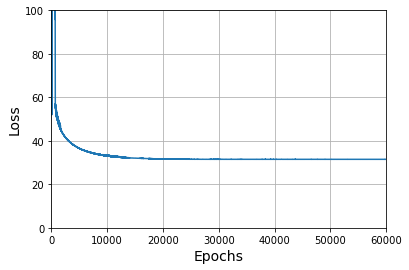

In [40]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

학습된 절편(b)와 특성 파라미터(w)는 다음과 같다.

In [41]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


**사이킷런의 SVC 모델과의 성능 비교**

동일한 데이터셋에 대해 사이킷런의 SVC 모델을 사용한다.
조기종료 조건 `tol=1e-3`이 충족될 때까지 반복 학습함에도 불구하고 학습 속도가 훨씬 빠르다.

In [42]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())

SVC(C=2, kernel='linear')

학습된 w와 b는 매우 이전과 매우 유사하다.

In [43]:
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


실제로 두 모델의 성능을 그래프로 그려보면 다음과 같다.

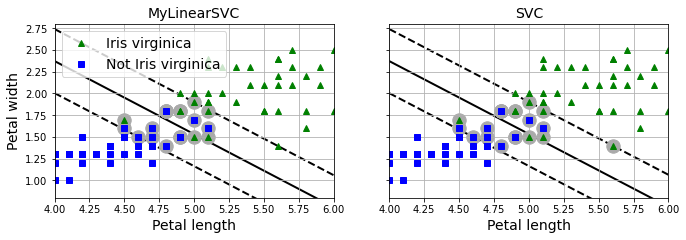

In [44]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("MyLinearSVC")
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length")
plt.title("SVC")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()

**SGDClassifier 모델과의 성능 비교**

`SGDClassifier` 모델을 SVM 용도로 훈련시키기 위해 힌지 손실 함수를 사용한다. 

In [45]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3,
                        random_state=42)
sgd_clf.fit(X, y)

SGDClassifier(alpha=0.017, random_state=42)

`SGDClassifier` 모델은 원래 SVM 용도로 만들어지지 않았기에 서포트 벡터에 대한 정보를 제공하지 않는다.
아래 코드는 필요한 정보를 구하는 방버을 보여주며 이를 이용하여 결정 경계 도로를 함께 그려준다.

__주의사항:__ 파라미터를 $\theta_0, \dots, \theta_n$으로 사용한다. 즉, 다음이 성립한다.

$$
\begin{align*}
\theta_0 &= b \\
\theta_i &= w_i\quad (i = 1, \dots, n)
\end{align*}
$$

[-12.52988101   1.94162342   1.84544824]


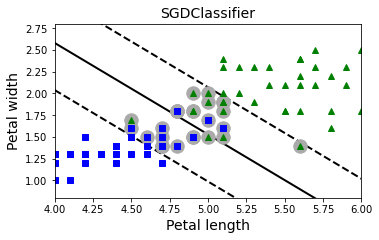

In [46]:
m = len(X)
t = np.array(y).reshape(-1, 1) * 2 - 1  # -1 if y == 0, or +1 if y == 1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5, 3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("SGDClassifier")
plt.axis([4, 6, 0.8, 2.8])

plt.show()

## 연습문제

## 1. to 8.

1. The fundamental idea behind Support Vector Machines is to fit the widest possible "street" between the classes. In other words, the goal is to have the largest possible margin between the decision boundary that separates the two classes and the training instances. When performing soft margin classification, the SVM searches for a compromise between perfectly separating the two classes and having the widest possible street (i.e., a few instances may end up on the street). Another key idea is to use kernels when training on nonlinear datasets. SVMs can also be tweaked to perform linear and nonlinear regression, as well as novelty detection.
2. After training an SVM, a _support vector_ is any instance located on the "street" (see the previous answer), including its border. The decision boundary is entirely determined by the support vectors. Any instance that is _not_ a support vector (i.e., is off the street) has no influence whatsoever; you could remove them, add more instances, or move them around, and as long as they stay off the street they won't affect the decision boundary. Computing the predictions with a kernelized SVM only involves the support vectors, not the whole training set.
3. SVMs try to fit the largest possible "street" between the classes (see the first answer), so if the training set is not scaled, the SVM will tend to neglect small features (see Figure 5–2).
4. You can use the `decision_function()` method to get confidence scores. These scores represent the distance between the instance and the decision boundary. However, they cannot be directly converted into an estimation of the class probability. If you set `probability=True` when creating an `SVC`, then at the end of training it will use 5-fold cross-validation to generate out-of-sample scores for the training samples, and it will train a `LogisticRegression` model to map these scores to estimated probabilities. The `predict_proba()` and `predict_log_proba()` methods will then be available.
5. All three classes can be used for large-margin linear classification. The `SVC` class also supports the kernel trick, which makes it capable of handling nonlinear tasks. However, this comes at a cost: the `SVC` class does not scale well to datasets with many instances. It does scale well to a large number of features, though. The `LinearSVC` class implements an optimized algorithm for linear SVMs, while `SGDClassifier` uses Stochastic Gradient Descent. Depending on the dataset `LinearSVC` may be a bit faster than `SGDClassifier`, but not always, and `SGDClassifier` is more flexible, plus it supports incremental learning.
6. If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. To decrease it, you need to increase `gamma` or `C` (or both).
7. A Regression SVM model tries to fit as many instances within a small margin around its predictions. If you add instances within this margin, the model will not be affected at all: it is said to be _ϵ-insensitive_.
8. The kernel trick is mathematical technique that makes it possible to train a nonlinear SVM model. The resulting model is equivalent to mapping the inputs to another space using a nonlinear transformation, then training a linear SVM on the resulting high-dimensional inputs. The kernel trick gives the same result without having to transform the inputs at all.

# 9.

_Exercise: Train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [56]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Now let's build and train 3 models:
* Remember that `LinearSVC` uses `loss="squared_hinge"` by default, so if we want all 3 models to produce similar results, we need to set `loss="hinge"`.
* Also, the `SVC` class uses an RBF kernel by default, so we need to set `kernel="linear"` to get similar results as the other two models.
* Lastly, the `SGDClassifier` class does not have a `C` hyperparameter, but it has another regularization hyperparameter called `alpha`, so we can tweak it to get similar results as the other two models.

In [57]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 0.05

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42).fit(X_scaled, y)
svc_clf = SVC(kernel="linear", C=C).fit(X_scaled, y)
sgd_clf = SGDClassifier(alpha=alpha, random_state=42).fit(X_scaled, y)

Let's plot the decision boundaries of these three models:

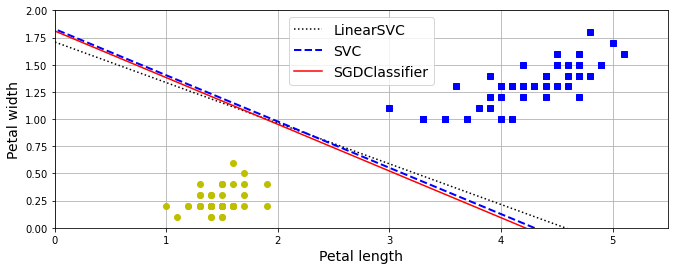

In [58]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

Close enough!

**참고**

아래 코드는 힌지 손실 함수와 제곱 힌지 손실 함수의 그래프를 그린다.

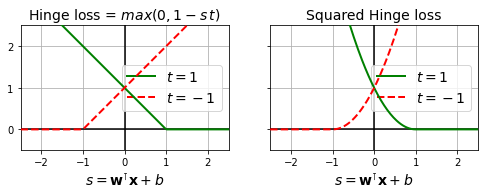

In [45]:
s = np.linspace(-2.5, 2.5, 200)
hinge_pos = np.where(1 - s < 0, 0, 1 - s)  # max(0, 1 - s)
hinge_neg = np.where(1 + s < 0, 0, 1 + s)  # max(0, 1 + s)

titles = (r"Hinge loss = $max(0, 1 - s\,t)$", r"Squared Hinge loss")

fix, axs = plt.subplots(1, 2, sharey=True, figsize=(8.2, 3))

for ax, loss_pos, loss_neg, title in zip(
        axs, (hinge_pos, hinge_pos ** 2), (hinge_neg, hinge_neg ** 2), titles):
    ax.plot(s, loss_pos, "g-", linewidth=2, zorder=10, label="$t=1$")
    ax.plot(s, loss_neg, "r--", linewidth=2, zorder=10, label="$t=-1$")
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlabel(r"$s = \mathbf{w}^\intercal \mathbf{x} + b$")
    ax.axis([-2.5, 2.5, -0.5, 2.5])
    ax.legend(loc="center right")
    ax.set_title(title)
    ax.set_yticks(np.arange(0, 2.5, 1))
    ax.set_aspect("equal")

plt.show()

# 10.

_Exercise: Train an SVM classifier on the Wine dataset, which you can load using `sklearn.datasets.load_wine()`. This dataset contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?_

First, let's fetch the dataset, look at its description, then split it into a training set and a test set:

In [59]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [60]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42)

In [62]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [63]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int64

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do to handle multiple classes. Easy, right?

In [64]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

/home/gslee/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

Oh no! It failed to converge. Can you guess why? Do you think we must just increase the number of training iterations? Let's see:

In [65]:
lin_clf = LinearSVC(max_iter=1_000_000, random_state=42)
lin_clf.fit(X_train, y_train)

/home/gslee/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=1000000, random_state=42)

Even with one million iterations, it still did not converge. There must be another problem.

Let's still evaluate this model with `cross_val_score`, it will serve as a baseline:

In [66]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

/home/gslee/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gslee/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gslee/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gslee/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/gslee/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.90997150997151

Well 91% accuracy on this dataset is not great. So did you guess what the problem is?

That's right, we forgot to scale the features! Always remember to scale the features when using SVMs:

In [67]:
lin_clf = make_pipeline(StandardScaler(),
                        LinearSVC(random_state=42))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

Now it converges without any problem. Let's measure its performance:

In [68]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

0.9774928774928775

Nice! We get 97.7% accuracy, that's much better.

Let's see if a kernelized SVM will do better. We will use a default `SVC` for now:

In [69]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
cross_val_score(svm_clf, X_train, y_train).mean()

0.9698005698005698

That's not better, but perhaps we need to do a bit of hyperparameter tuning:

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distrib = {
    "svc__gamma": reciprocal(0.001, 0.1),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=9.925589984899778, gamma=0.011986281799901176,
                     random_state=42))])

In [71]:
rnd_search_cv.best_score_

0.9925925925925926

Ah, this looks excellent! Let's select this model. Now we can test it on the test set:

In [72]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

This tuned kernelized SVM performs better than the `LinearSVC` model, but we get a lower score on the test set than we measured using cross-validation. This is quite common: since we did so much hyperparameter tuning, we ended up slightly overfitting the cross-validation test sets. It's tempting to tweak the hyperparameters a bit more until we get a better result on the test set, but we this would probably not help, as we would just start overfitting the test set. Anyway, this score is not bad at all, so let's stop here.

## 11.

_Exercise: Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2. The original dataset can be fetched using `sklearn.datasets.fetch_california_housing()`. The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use much less instances (e.g., 2,000), to test many more hyperparameter combinations. What is your best model's RMSE?_

Let's load the dataset:

In [73]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

Split it into a training set and a test set:

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

Don't forget to scale the data:

Let's train a simple `LinearSVR` first:

In [75]:
from sklearn.svm import LinearSVR

lin_svr = make_pipeline(StandardScaler(), LinearSVR(random_state=42))
lin_svr.fit(X_train, y_train)

/home/gslee/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=42))])

It did not converge, so let's increase `max_iter`:

In [76]:
lin_svr = make_pipeline(StandardScaler(),
                        LinearSVR(max_iter=5000, random_state=42))
lin_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(max_iter=5000, random_state=42))])

Let's see how it performs on the training set:

In [77]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mse

0.9595484665813284

Let's look at the RMSE:

In [78]:
np.sqrt(mse)

0.979565447829459

In this dataset, the targets represent hundreds of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors close to $98,000! Not great. Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [79]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svm_clf = make_pipeline(StandardScaler(), SVR())

param_distrib = {
    "svr__gamma": reciprocal(0.001, 0.1),
    "svr__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib,
                                   n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc115e62340>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc10c694fd0>},
                   random_state=42)

In [80]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=4.63629602379294, gamma=0.08781408196485974))])

In [81]:
-cross_val_score(rnd_search_cv.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [82]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.5854732265172221

So SVMs worked very well on the Wine dataset, but not so much on the California Housing dataset. In Chapter 2, we found that Random Forests worked better for that dataset.

And that's all for today!